In [2]:
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image #help to work with images

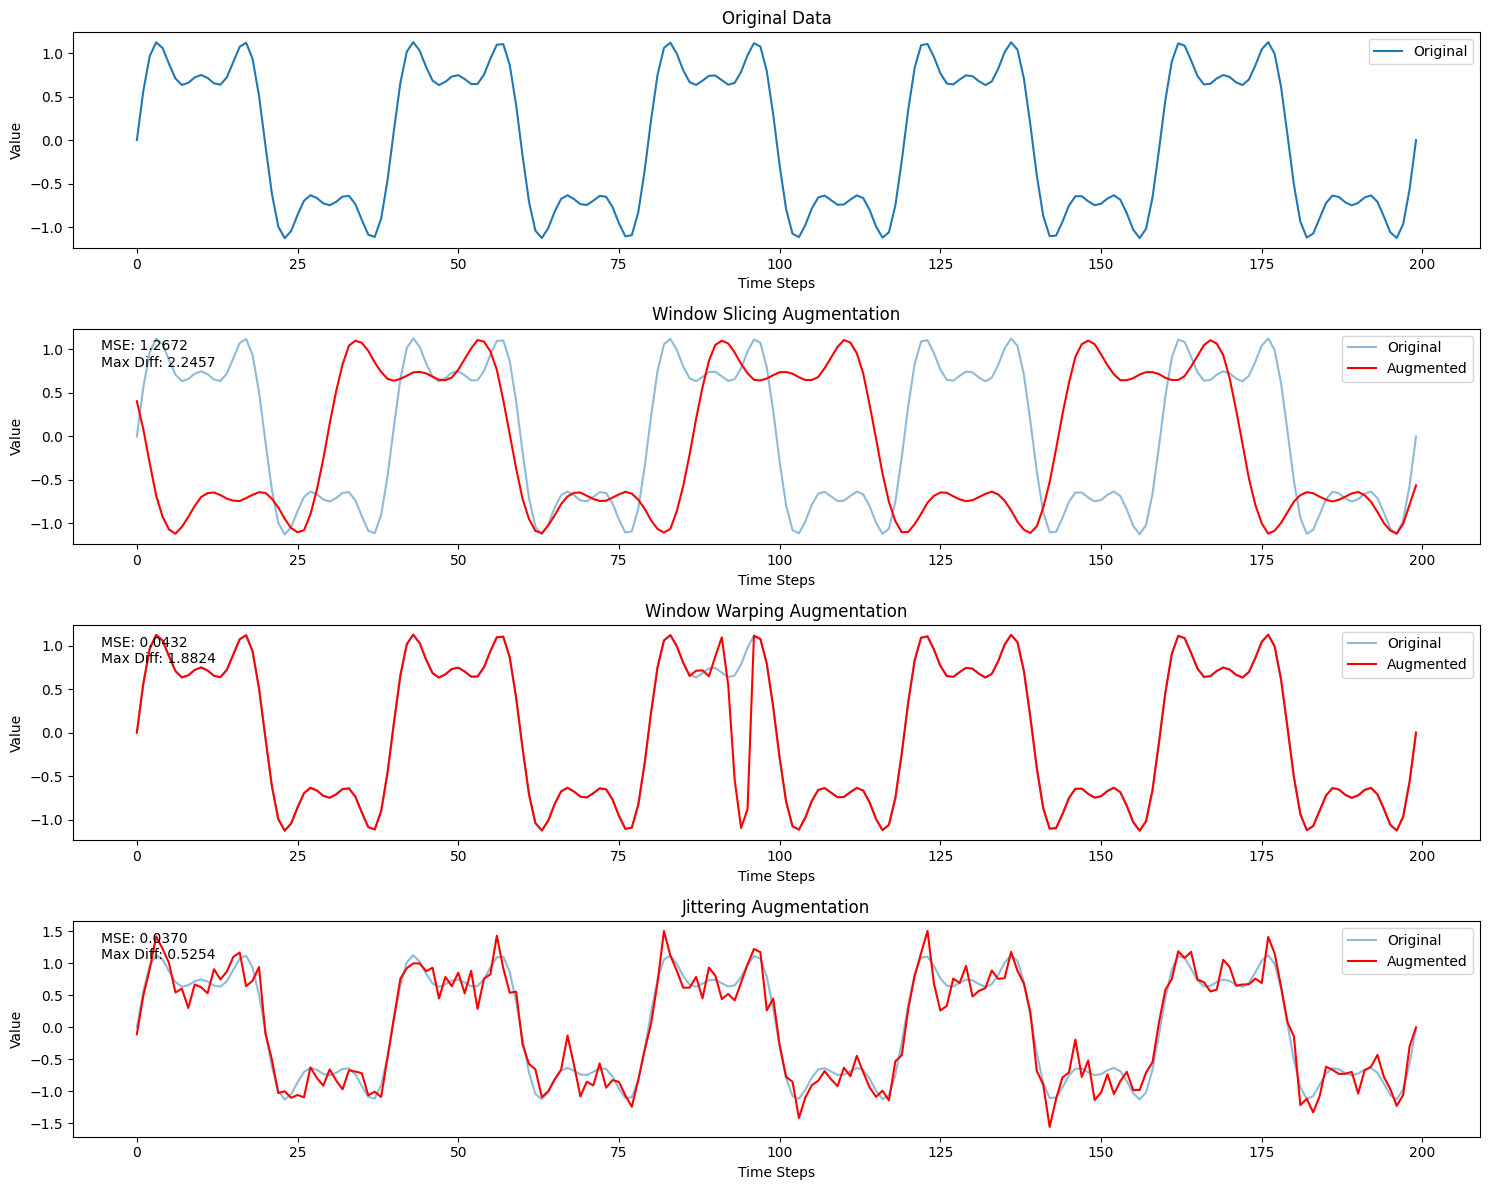

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.169412].


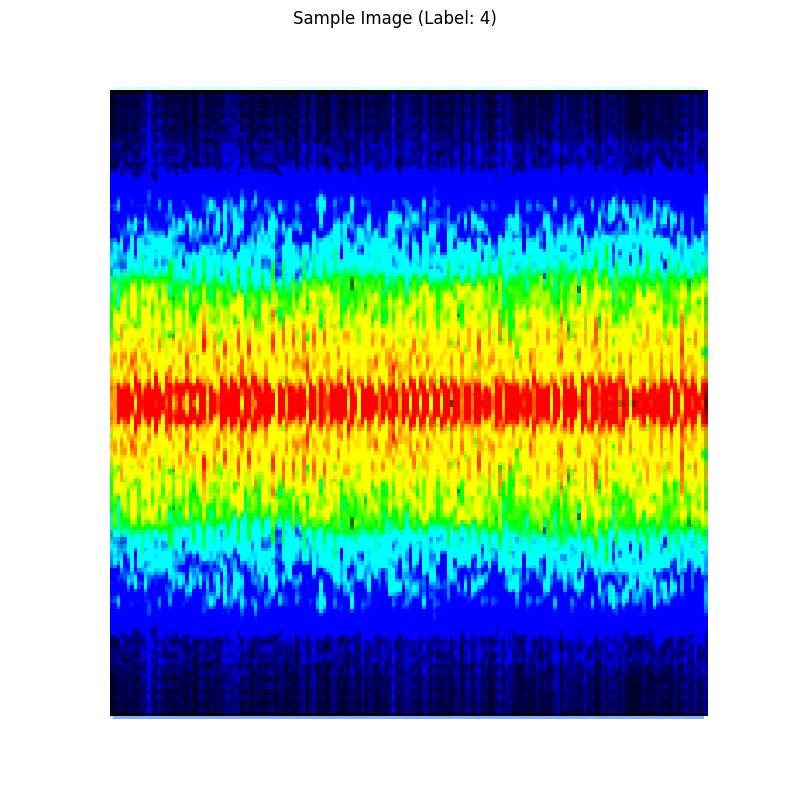

Dataset Details:
Total Images: 4849
Training Images: 4121
Validation Images: 242
Test Images: 486


In [4]:
# %% [markdown]
# # Time-Variant Data Augmentation Techniques

# %% Imports
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# %% Time-Variant Data Augmentation Techniques
class TimeVariantDataAugmentation:
    @staticmethod
    def window_slicing(data, slice_percentage=0.9):
        """
        Perform window slicing on time-variant data
        
        Args:
            data (torch.Tensor): Input time-variant data
            slice_percentage (float): Percentage of original width to keep (default: 0.9)
        
        Returns:
            torch.Tensor: Augmented time-variant data
        """
        # Ensure input is a torch tensor
        if not isinstance(data, torch.Tensor):
            data = torch.tensor(data, dtype=torch.float32)
        
        # Get original dimensions
        orig_width = data.shape[1]
        
        # Calculate slice width
        slice_width = int(orig_width * slice_percentage)
        
        # Generate random starting point
        max_start = orig_width - slice_width
        start_point = torch.randint(0, max_start + 1, (1,)).item()
        
        # Extract slice
        sliced_data = data[:, start_point:start_point + slice_width]
        
        # Interpolate back to original size
        augmented_data = torch.nn.functional.interpolate(
            sliced_data.unsqueeze(0), 
            size=orig_width, 
            mode='linear', 
            align_corners=False
        ).squeeze(0)
        
        return augmented_data

    @staticmethod
    def window_warping(data, warping_factors=[0.5, 2.0]):
        """
        Perform window warping on time-variant data
        
        Args:
            data (torch.Tensor): Input time-variant data
            warping_factors (list): Warping factors to apply (default: [0.5, 2.0])
        
        Returns:
            torch.Tensor: Augmented time-variant data
        """
        # Ensure input is a torch tensor
        if not isinstance(data, torch.Tensor):
            data = torch.tensor(data, dtype=torch.float32)
        
        # Get original dimensions
        orig_width = data.shape[1]
        
        # Select window (10% of original width)
        window_width = int(orig_width * 0.1)
        start_point = torch.randint(0, orig_width - window_width + 1, (1,)).item()
        
        # Select random warping factor
        warping_factor = np.random.choice(warping_factors)
        
        # Extract window
        window = data[:, start_point:start_point + window_width]
        
        # Warp window
        warped_window_width = int(window_width * warping_factor)
        warped_window = torch.nn.functional.interpolate(
            window.unsqueeze(0), 
            size=warped_window_width, 
            mode='linear', 
            align_corners=False
        ).squeeze(0)
        
        # Reconstruct full data
        augmented_data = data.clone()
        end_point = start_point + warped_window_width
        
        # Replace window section with warped window
        if warped_window_width < window_width:
            augmented_data[:, start_point:end_point] = warped_window
        else:
            augmented_data[:, start_point:start_point + window_width] = warped_window[:window_width]
        
        return augmented_data

    @staticmethod
    def jittering(data, mean=0, std_dev=0.03):
        """
        Add Gaussian noise to time-variant data
        
        Args:
            data (torch.Tensor): Input time-variant data
            mean (float): Mean of Gaussian noise
            std_dev (float): Standard deviation of Gaussian noise
        
        Returns:
            torch.Tensor: Augmented time-variant data
        """
        # Ensure input is a torch tensor
        if not isinstance(data, torch.Tensor):
            data = torch.tensor(data, dtype=torch.float32)
        
        # Generate Gaussian noise
        noise = torch.normal(mean, std_dev, size=data.shape)
        
        # Add noise to original data
        augmented_data = data + noise
        
        return augmented_data

# %% Stochastic Augmentation Class
class StochasticAugmentation:
    def __init__(self, augmentation_methods):
        """
        Create a stochastic augmentation pipeline
        
        Args:
            augmentation_methods (list): List of augmentation methods to choose from
        """
        self.augmentation_methods = augmentation_methods
    
    def __call__(self, data):
        """
        Randomly select and apply one augmentation method
        
        Args:
            data (torch.Tensor): Input time-variant data
        
        Returns:
            torch.Tensor: Augmented time-variant data
        """
        # Randomly select an augmentation method
        method = np.random.choice(self.augmentation_methods)
        
        # Apply the selected method
        return method(data)

# %% Custom Image Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, base_dir, subfolders, transform=None, label_encoder=None):
        self.base_dir = base_dir
        self.subfolders = subfolders
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        for subfolder in subfolders:
            folder_path = os.path.join(base_dir, subfolder)
            label = subfolder
            
            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(folder_path, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(label)
        
        if label_encoder is not None:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.labels)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

# %% Augmentation Visualization Function
def visualize_augmentation():
    # Create more complex sample data with multiple frequencies
    t = torch.linspace(0, 10*torch.pi, 200)
    sample_data = torch.sin(t) + 0.5 * torch.sin(3*t) + 0.25 * torch.sin(5*t)
    sample_data = sample_data.unsqueeze(0)
    
    # Create augmentation methods with specific transformations
    augmentation_methods = [
        ("Window Slicing", lambda x: TimeVariantDataAugmentation.window_slicing(x, slice_percentage=0.7)),
        ("Window Warping", lambda x: TimeVariantDataAugmentation.window_warping(x, warping_factors=[0.5])),
        ("Jittering", lambda x: TimeVariantDataAugmentation.jittering(x, mean=0, std_dev=0.2))
    ]
    
    # Visualization
    plt.figure(figsize=(15, 12))
    
    # Original Data
    plt.subplot(4, 1, 1)
    plt.title("Original Data")
    plt.plot(sample_data.numpy().flatten(), label='Original')
    plt.legend()
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    
    # Augmentations with Difference Plots
    for i, (name, aug_method) in enumerate(augmentation_methods, start=2):
        # Apply augmentation
        augmented_data = aug_method(sample_data)
        
        # Augmented Data Subplot
        plt.subplot(4, 1, i)
        plt.title(f"{name} Augmentation")
        plt.plot(sample_data.numpy().flatten(), label='Original', alpha=0.5)
        plt.plot(augmented_data.numpy().flatten(), label='Augmented', color='red')
        plt.legend()
        plt.xlabel("Time Steps")
        plt.ylabel("Value")
        
        # Calculate and display difference metrics
        mse = torch.nn.functional.mse_loss(sample_data, augmented_data).item()
        max_diff = torch.max(torch.abs(augmented_data - sample_data)).item()
        
        plt.text(0.02, 0.95, f"MSE: {mse:.4f}\nMax Diff: {max_diff:.4f}", 
                 transform=plt.gca().transAxes, 
                 verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

# %% Define dataset parameters
base_dir = r'DIAT-uSAT_dataset'
subfolders = [
    "3_long_blade_rotor",
    "3_short_blade_rotor", 
    "Bird", 
    "Bird+mini-helicopter", 
    "drone", 
    "rc_plane"
]

# %% Prepare Label Encoder
label_encoder = LabelEncoder()
label_encoder.fit(subfolders)

# %% Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# %% Load dataset
dataset = CustomImageDataset(base_dir, subfolders, transform=transform, label_encoder=label_encoder)

# %% Seed and shuffle
torch.manual_seed(42)
indices = torch.randperm(len(dataset))
shuffled_dataset = Subset(dataset, indices)

# %% Split dataset
train_size = int(0.85 * len(shuffled_dataset))
val_size = int(0.05 * len(shuffled_dataset))
test_size = len(shuffled_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(shuffled_dataset, [train_size, val_size, test_size])

# %% Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# %% Visualize Augmentation
visualize_augmentation()

# %% Visualize one sample from dataset
sample_image, sample_label = next(iter(train_loader))
sample_image = sample_image[0]
sample_image = sample_image.permute(1, 2, 0)

plt.figure(figsize=(10, 10))
plt.imshow(sample_image)
plt.title(f"Sample Image (Label: {sample_label[0]})")
plt.axis('off')
plt.show()

# %% Print dataset details
print("Dataset Details:")
print(f"Total Images: {len(dataset)}")
print(f"Training Images: {len(train_dataset)}")
print(f"Validation Images: {len(val_dataset)}")
print(f"Test Images: {len(test_dataset)}")

In [6]:
# Load dataset
dataset = CustomImageDataset(base_dir, subfolders, transform=transform, label_encoder=label_encoder)

In [5]:
train_size = int(0.85 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [7]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from tqdm import tqdm

# Define the Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 1, kernel_size=1)  # Reduce channels to 1
        self.conv2 = nn.Conv2d(1, 1, kernel_size=3, padding=1)  # Learn spatial weights
        self.sigmoid = nn.Sigmoid()  # Normalize attention map to [0, 1]

    def forward(self, x):
        attn = self.conv1(x)  # Reduce channel dimension
        attn = self.conv2(attn)  # Learn spatial relationships
        attn = self.sigmoid(attn)  # Normalize
        return x * attn  # Apply attention

# Define the Custom CNN with integrated Spatial Attention
class CustomCNNWithAttention(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomCNNWithAttention, self).__init__()
        # 1st Convolutional Block
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 2nd Convolutional Block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3rd Convolutional Block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 4th Convolutional Block
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Attention Module
        self.attention = SpatialAttention(in_channels=128)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, num_classes)  # Output for `num_classes` classes

        # Dropout for Regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # 1st Convolutional Block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        # 2nd Convolutional Block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # 3rd Convolutional Block
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # 4th Convolutional Block
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        # Apply Attention Mechanism
        x = self.attention(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        
        # Flatten the output
        x = torch.flatten(x, 1)
        
        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Train and Validation Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = model.to(device)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 30)

        # Training Phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device)
            labels = labels.to(device).long()  # Ensure labels are of type torch.long

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            # Backward Pass and Optimization
            loss.backward()
            optimizer.step()

            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_train += labels.size(0)

        # Adjust learning rate
        scheduler.step()

        epoch_loss = running_loss / total_train
        epoch_acc = running_corrects.double() / total_train

        print(f"Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Validation Phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs = inputs.to(device)
                labels = labels.to(device).long()  # Ensure labels are of type torch.long

                # Forward Pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                # Track statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_val += labels.size(0)

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = running_corrects.double() / total_val

        print(f"Validation Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

        # Save the best model
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            torch.save(model.state_dict(), "customcnnwithAttention.pth")

    print(f"Training complete. Best Validation Acc: {best_acc:.4f}")

# Example Usage
if __name__ == "__main__":
    # Assuming train_loader and val_loader are defined
    model_deepercnn = CustomCNNWithAttention(num_classes=6)
    criterion = nn.CrossEntropyLoss()

    optimizer_deepercnn = optim.Adam(model_deepercnn.parameters(), lr=0.001)
    scheduler_deepercnn = lr_scheduler.StepLR(optimizer_deepercnn, step_size=7, gamma=0.1)

    # Train the model
    train_model(model_deepercnn, train_loader, val_loader, criterion, optimizer_deepercnn, scheduler_deepercnn, num_epochs=20)


Epoch 1/20
------------------------------


Training: 100%|██████████| 516/516 [01:14<00:00,  6.96it/s]


Training Loss: 0.8376 Acc: 0.6717


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.47it/s]


Validation Loss: 0.5899 Acc: 0.7810
Epoch 2/20
------------------------------


Training: 100%|██████████| 516/516 [02:04<00:00,  4.15it/s]


Training Loss: 0.4635 Acc: 0.8398


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.43it/s]


Validation Loss: 1.0286 Acc: 0.6694
Epoch 3/20
------------------------------


Training: 100%|██████████| 516/516 [01:06<00:00,  7.74it/s]


Training Loss: 0.3725 Acc: 0.8760


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.92it/s]


Validation Loss: 0.3632 Acc: 0.8430
Epoch 4/20
------------------------------


Training: 100%|██████████| 516/516 [01:06<00:00,  7.72it/s]


Training Loss: 0.2876 Acc: 0.8991


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.84it/s]


Validation Loss: 0.1987 Acc: 0.9421
Epoch 5/20
------------------------------


Training: 100%|██████████| 516/516 [01:23<00:00,  6.19it/s]


Training Loss: 0.2244 Acc: 0.9204


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.28it/s]


Validation Loss: 0.1300 Acc: 0.9628
Epoch 6/20
------------------------------


Training: 100%|██████████| 516/516 [02:13<00:00,  3.87it/s]


Training Loss: 0.1765 Acc: 0.9364


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.39it/s]


Validation Loss: 0.1446 Acc: 0.9545
Epoch 7/20
------------------------------


Training: 100%|██████████| 516/516 [01:12<00:00,  7.09it/s]


Training Loss: 0.1840 Acc: 0.9369


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.91it/s]


Validation Loss: 0.1111 Acc: 0.9504
Epoch 8/20
------------------------------


Training: 100%|██████████| 516/516 [01:04<00:00,  7.97it/s]


Training Loss: 0.0949 Acc: 0.9709


Validation: 100%|██████████| 31/31 [00:05<00:00,  5.61it/s]


Validation Loss: 0.0643 Acc: 0.9793
Epoch 9/20
------------------------------


Training: 100%|██████████| 516/516 [02:06<00:00,  4.09it/s]


Training Loss: 0.0734 Acc: 0.9757


Validation: 100%|██████████| 31/31 [00:07<00:00,  4.06it/s]


Validation Loss: 0.0670 Acc: 0.9752
Epoch 10/20
------------------------------


Training: 100%|██████████| 516/516 [02:15<00:00,  3.81it/s]


Training Loss: 0.0596 Acc: 0.9791


Validation: 100%|██████████| 31/31 [00:07<00:00,  3.97it/s]


Validation Loss: 0.0590 Acc: 0.9752
Epoch 11/20
------------------------------


Training: 100%|██████████| 516/516 [01:17<00:00,  6.69it/s]


Training Loss: 0.0617 Acc: 0.9811


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.75it/s]


Validation Loss: 0.0857 Acc: 0.9628
Epoch 12/20
------------------------------


Training: 100%|██████████| 516/516 [01:05<00:00,  7.89it/s]


Training Loss: 0.0572 Acc: 0.9813


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.77it/s]


Validation Loss: 0.0622 Acc: 0.9752
Epoch 13/20
------------------------------


Training: 100%|██████████| 516/516 [01:09<00:00,  7.38it/s]


Training Loss: 0.0581 Acc: 0.9808


Validation: 100%|██████████| 31/31 [00:08<00:00,  3.86it/s]


Validation Loss: 0.0446 Acc: 0.9835
Epoch 14/20
------------------------------


Training: 100%|██████████| 516/516 [01:15<00:00,  6.80it/s]


Training Loss: 0.0536 Acc: 0.9842


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.89it/s]


Validation Loss: 0.0394 Acc: 0.9835
Epoch 15/20
------------------------------


Training: 100%|██████████| 516/516 [01:03<00:00,  8.07it/s]


Training Loss: 0.0398 Acc: 0.9874


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.96it/s]


Validation Loss: 0.0329 Acc: 0.9876
Epoch 16/20
------------------------------


Training: 100%|██████████| 516/516 [01:04<00:00,  7.95it/s]


Training Loss: 0.0419 Acc: 0.9871


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.94it/s]


Validation Loss: 0.0393 Acc: 0.9876
Epoch 17/20
------------------------------


Training: 100%|██████████| 516/516 [01:04<00:00,  8.04it/s]


Training Loss: 0.0380 Acc: 0.9888


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.93it/s]


Validation Loss: 0.0362 Acc: 0.9793
Epoch 18/20
------------------------------


Training: 100%|██████████| 516/516 [01:04<00:00,  8.04it/s]


Training Loss: 0.0353 Acc: 0.9888


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.88it/s]


Validation Loss: 0.0415 Acc: 0.9793
Epoch 19/20
------------------------------


Training: 100%|██████████| 516/516 [01:05<00:00,  7.86it/s]


Training Loss: 0.0372 Acc: 0.9876


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.68it/s]


Validation Loss: 0.0347 Acc: 0.9835
Epoch 20/20
------------------------------


Training: 100%|██████████| 516/516 [01:03<00:00,  8.09it/s]


Training Loss: 0.0330 Acc: 0.9908


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.83it/s]

Validation Loss: 0.0374 Acc: 0.9876
Training complete. Best Validation Acc: 0.9876


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Function to plot ROC-AUC Curve
def plot_roc_curve(model, test_loader, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()

            # Forward pass
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Get probabilities

            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Compute ROC curve and ROC area for each class
    for i in range(y_scores.shape[1]):
        fpr, tpr, _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot training and validation metrics
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Loss Curves
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Accuracy Curves
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Testing Function with Metrics
def test_model_with_metrics(model, test_loader, criterion, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_test = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device).long()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_test += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    test_loss = running_loss / total_test
    test_acc = running_corrects.double() / total_test

    print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(model.fc2.out_features), yticklabels=range(model.fc2.out_features))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    return test_loss, test_acc

# Example Usage for Testing and Visualization
if __name__ == "__main__":
    # Assuming test_loader is defined
    model_deepercnn = CustomCNNWithAttention(num_classes=6)
    model_deepercnn.load_state_dict(torch.load("customcnnwithAttention.pth"))  # Load trained model
    model_deepercnn = model_deepercnn.to("cuda" if torch.cuda.is_available() else "cpu")

    criterion = nn.CrossEntropyLoss()

    # Test the model and plot metrics
    test_loss, test_acc = test_model_with_metrics(model_deepercnn, test_loader, criterion)

    # Plot ROC-AUC Curve
    plot_roc_curve(model_deepercnn, test_loader)

    # Plot Training and Validation Metrics (assuming you have saved the history)
    history = {
        "train_loss": [0.8, 0.6, 0.4],
        "val_loss": [0.9, 0.7, 0.5],
        "train_acc": [0.7, 0.8, 0.9],
        "val_acc": [0.6, 0.75, 0.85],
    }
    plot_training_curves(history)


ModuleNotFoundError: No module named 'seaborn'

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from tqdm import tqdm

# Define the Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 1, kernel_size=1)  # Reduce channels to 1
        self.conv2 = nn.Conv2d(1, 1, kernel_size=3, padding=1)  # Learn spatial weights
        self.sigmoid = nn.Sigmoid()  # Normalize attention map to [0, 1]

    def forward(self, x):
        attn = self.conv1(x)  # Reduce channel dimension
        attn = self.conv2(attn)  # Learn spatial relationships
        attn = self.sigmoid(attn)  # Normalize
        return x * attn  # Apply attention

# Define the Custom CNN with integrated Spatial Attention
class CustomCNNWithAttention(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomCNNWithAttention, self).__init__()
        # 1st Convolutional Block
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 2nd Convolutional Block
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 3rd Convolutional Block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 4th Convolutional Block
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Attention Module
        self.attention = SpatialAttention(in_channels=128)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, num_classes)  # Output for `num_classes` classes

        # Dropout for Regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # 1st Convolutional Block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        # 2nd Convolutional Block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # 3rd Convolutional Block
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # 4th Convolutional Block
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        # Apply Attention Mechanism
        x = self.attention(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        
        # Flatten the output
        x = torch.flatten(x, 1)
        
        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Train and Validation Function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = model.to(device)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 30)

        # Training Phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device)
            labels = labels.to(device).long()  # Ensure labels are of type torch.long

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            # Backward Pass and Optimization
            loss.backward()
            optimizer.step()

            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_train += labels.size(0)

        # Adjust learning rate
        scheduler.step()

        epoch_loss = running_loss / total_train
        epoch_acc = running_corrects.double() / total_train

        print(f"Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Validation Phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs = inputs.to(device)
                labels = labels.to(device).long()  # Ensure labels are of type torch.long

                # Forward Pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                # Track statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_val += labels.size(0)

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = running_corrects.double() / total_val

        print(f"Validation Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

        # Save the best model
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            torch.save(model.state_dict(), "customcnnwithAttention.pth")

    print(f"Training complete. Best Validation Acc: {best_acc:.4f}")

# Example Usage
if __name__ == "__main__":
    # Assuming train_loader and val_loader are defined
    model_deepercnn = CustomCNNWithAttention(num_classes=6)
    criterion = nn.CrossEntropyLoss()

    optimizer_deepercnn = optim.Adam(model_deepercnn.parameters(), lr=0.001)
    scheduler_deepercnn = lr_scheduler.StepLR(optimizer_deepercnn, step_size=7, gamma=0.1)

    # Train the model
    train_model(model_deepercnn, train_loader, val_loader, criterion, optimizer_deepercnn, scheduler_deepercnn, num_epochs=20)


Epoch 1/20
------------------------------


Training:  13%|█▎        | 69/516 [00:13<01:29,  4.99it/s]


KeyboardInterrupt: 

C:\Users\Shravya H Jain\AppData\Local\Temp\ipykernel_7300\3287528403.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_deepercnn.load_state_dict(torch.load("customc

Test Loss: 0.0853 Test Acc: 0.9753

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.95      0.94      0.95        84
     Class 1       0.93      0.95      0.94        80
     Class 2       1.00      1.00      1.00        80
     Class 3       1.00      0.98      0.99        84
     Class 4       1.00      1.00      1.00        78
     Class 5       0.98      0.99      0.98        80

    accuracy                           0.98       486
   macro avg       0.98      0.98      0.98       486
weighted avg       0.98      0.98      0.98       486


Confusion Matrix:
[[79  5  0  0  0  0]
 [ 4 76  0  0  0  0]
 [ 0  0 80  0  0  0]
 [ 0  0  0 82  0  2]
 [ 0  0  0  0 78  0]
 [ 0  1  0  0  0 79]]


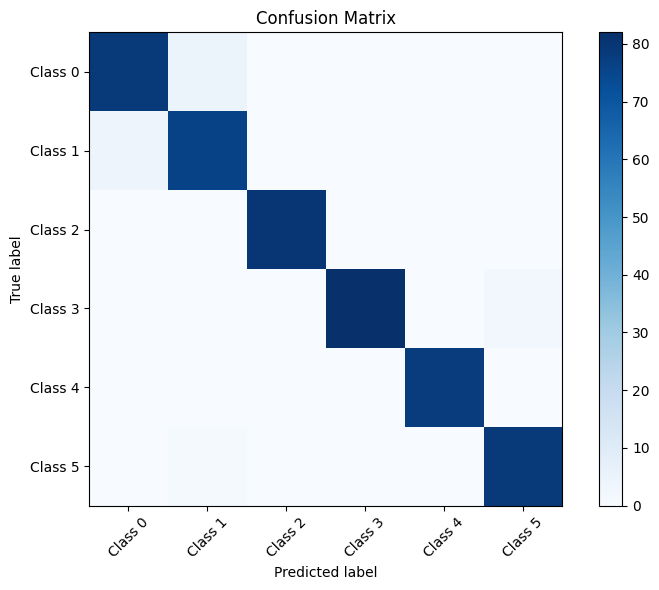

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Test Function
def test_model(model, test_loader, criterion, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = model.to(device)
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    total_test = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            labels = labels.to(device).long()  # Ensure labels are of type torch.long

            # Forward Pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_test += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / total_test
    test_acc = running_corrects.double() / total_test

    print(f"Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(6)]))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(6)
    plt.xticks(tick_marks, [f"Class {i}" for i in range(6)], rotation=45)
    plt.yticks(tick_marks, [f"Class {i}" for i in range(6)])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Example Usage
if __name__ == "__main__":
    # Assuming test_loader is defined
    model_deepercnn = CustomCNNWithAttention(num_classes=6)
    model_deepercnn.load_state_dict(torch.load("customcnnwithAttention.pth"))
    model_deepercnn.eval()

    criterion = nn.CrossEntropyLoss()

    # Test the model
    test_model(model_deepercnn, test_loader, criterion)


In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import torch

def test_model(model, test_loader, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()  # Ensure labels are of type torch.long

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Collect predictions and targets
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    # Generate Classification Report
    print("Classification Report:")
    print(classification_report(all_targets, all_preds, digits=4))

    # Generate Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(all_targets, all_preds))

# Example Usage
# Assuming test_loader is defined
if __name__ == "__main__":
    # Load the trained model weights
    model_deepercnn = CustomCNNWithAttention(num_classes=6)
    model_deepercnn.load_state_dict(torch.load("customcnnwithAttention.pth"))

    # Evaluate the model on test data
    test_model(model_deepercnn, test_loader)


C:\Users\Shravya H Jain\AppData\Local\Temp\ipykernel_7300\66978296.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_deepercnn.load_state_dict(torch.load("customcnn

Classification Report:
              precision    recall  f1-score   support

           0     0.9630    0.9286    0.9455        84
           1     0.9277    0.9625    0.9448        80
           2     1.0000    1.0000    1.0000        80
           3     1.0000    0.9762    0.9880        84
           4     1.0000    1.0000    1.0000        78
           5     0.9756    1.0000    0.9877        80

    accuracy                         0.9774       486
   macro avg     0.9777    0.9779    0.9776       486
weighted avg     0.9777    0.9774    0.9774       486

Confusion Matrix:
[[78  6  0  0  0  0]
 [ 3 77  0  0  0  0]
 [ 0  0 80  0  0  0]
 [ 0  0  0 82  0  2]
 [ 0  0  0  0 78  0]
 [ 0  0  0  0  0 80]]
